In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

import catboost
import lightgbm as lgb
import sklearn

import optuna
from optuna.samplers import TPESampler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-sep-2021/train.csv
/kaggle/input/tabular-playground-series-sep-2021/test.csv
/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv


### Notes

For tabular data, I believe that two of the main reasons for an increase in model accuracy are feature engineering, and creating additional forms of data that your model can not find on its own.

For example, one column may correspond to group_id. And maybe some groups are more likely to have a claim value of 1 versus 0. Given that there are so many different IDs and they are in no particular order, it would be difficult for an ML model to determine this by itself. If we created an additional column with the probability that each particular group_id was to have a claim value of 1, then this would be much easier for the model to interpret. 

Given that we do not know what each column corresponds to in this dataset, it will be difficult to perform
feature engineering on this set.

### Versions

- v1: Baseline - 0.790
- v3: Added Optuna Hyperparameter Optimizer - 0.791
- v4: Training on all data + increased range of hyperparameters(overfitting) - 0.776
- v5: Reduced hyperparameter range(still overfitting) - 0.783
- v6: Added hold-out set - 0.791
- v7: Setting new seed + Feature Importance - 0.793
- v11: Leave empty values as NAN/null - 0.802
- v12: Added NAN count feature - 0.812
- v13: 5-fold cross validation - 0.813
- v14: 10-fold cross validation - 0.813
- v15: Added skew/std of row - 0.813
- v16: Added "top-mean" - 0.814
- v17: Tested some features - 0.813
- v19: Change seed - 0.814
- v21: Cat-Boost + LGBM 10-fold - 0.814
- v22: Just Cat-Boost - 0.814
- v23: Removed Scalar + (Cat-Boost/LGBM 10-fold) - 0.817
- v25: Changed params + Seed - 0.816
- v26: 20-fold v25 - 0.817
- v27: added mad feature - 0.817
- V28: Changed how feats are calculated + Added pct_change() - 0.816
- V29: Removed PCT change - 0.817
- V30: Added Quantile + STD NAN's - 0.817
- V31: Seed + Removed 1 Feature - 

### Changes

At this point I am looking for a strong combination of parameters for a 10-fold catboost and 10-fold Lightgbm combined.

### Read and Train_Test_Split Data

Make the train_test_split before filling in for missing values, as we do not want any data leakage into the validation set!

In [2]:
#setting a seed for reproducability
seed = 1380

#reading training data
train_df = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')
train_df_labels = train_df['claim']
train_df = train_df.drop(columns=['claim','id'],axis=1)

#reading test_data
test_df = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')
submission_df = test_df['id'].to_frame()
test_df = test_df.drop(columns=['id'], axis=1)

print(train_df.shape)
print(train_df_labels.shape)

(957919, 118)
(957919,)


### Filling in Missing Values

As we can see from the first cell below there are plenty of missing values across the columns. It would be wise to analyze each column individually and find out what the best value the replace missing values would be, or to even replace the missing values at all.

In some cases this would be the mean, median, mode, or even an value associated with another column. 

After some testing, leaving the null values as null worked best. 

In [3]:
train_df.isnull().sum(axis = 0).sort_values(ascending=False)

f31     15678
f46     15633
f24     15630
f83     15627
f68     15619
        ...  
f72     15219
f118    15212
f104    15198
f2      15190
f102    15168
Length: 118, dtype: int64

### Feature engineering

Testing out adding a NAN count for each row as per reccomendation from this discussion thread --> [Add Number of Nans in A Row as a Feature](https://www.kaggle.com/c/tabular-playground-series-sep-2021/discussion/270206)

In [4]:
#train_df features
a = train_df.abs().sum(axis=1)
b = train_df.sem(axis=1)
c = train_df.max(axis=1)
d = train_df.min(axis=1)
e = train_df.std(axis=1)
f = train_df.skew(axis=1)
g = train_df.mean(axis=1)
h = train_df[["f40","f70","f47","f34","f35","f45"]].mean(axis=1)
i = train_df.isnull().sum(axis=1)
j = train_df.mad(axis=1)
k = train_df.quantile(axis=1)
l = train_df.isnull().std(axis=1)

train_df['abs_sum'] = a
train_df['sem'] = b
train_df['max'] = c
train_df['min'] = d
train_df['std'] = e
train_df['skew'] = f
train_df['mean'] = g
train_df["top_mean"] = h
train_df['NANs'] = i
train_df['mad'] = j
train_df['quantile'] = k
train_df['NANs_std'] = l

#test_df features
a = test_df.abs().sum(axis=1)
b = test_df.sem(axis=1)
c = test_df.max(axis=1)
d = test_df.min(axis=1)
e = test_df.std(axis=1)
f = test_df.skew(axis=1)
g = test_df.mean(axis=1)
h = test_df[["f40","f70","f47","f34","f35","f45"]].mean(axis=1)
i = test_df.isnull().sum(axis=1)
j = test_df.mad(axis=1)
k = test_df.quantile(axis=1)
l = test_df.isnull().std(axis=1)

test_df['abs_sum'] = a
test_df['sem'] = b
test_df['max'] = c
test_df['min'] = d
test_df['std'] = e
test_df['skew'] = f
test_df['mean'] = g
test_df["top_mean"] = h
test_df['NANs'] = i
test_df['mad'] = j
test_df['quantile'] = k
test_df['NANs_std'] = l

del a,b,c,d,e,f,g,h,i,j,k,l

### Scaling Value between 0-1

MinMaxScaler() - Transforms all of the columns into a range between 0-1

We are fitting the range of this on the training data, and then using that scaler to scale both the training and test datasets.

When we do fit it to the test data, we may see values that are above and below the max/min range of the training data and so we are going to map any value below zero to zero, and any values above one to one.

In [5]:
#Defining and fitting minmaxscaler on train_data
# scaler = MinMaxScaler() 
# scaler.fit(train_df)

In [6]:
#fitting scaler and mapping outliers in test data to 0 or 1
#keeps as pd.dataframe after scaler applied
# train_df = pd.DataFrame(scaler.fit_transform(train_df),columns = train_df.columns)

# valid_df = pd.DataFrame(scaler.fit_transform(valid_df),columns = valid_df.columns)

# valid_df[valid_df < 0] = 0
# valid_df[valid_df > 1] = 1

### Training with Optuna

Found a great article here on hyperparameter optimization with Optuna. Really helps break down the functionality of each parameter.

https://neptune.ai/blog/lightgbm-parameters-guide

We are also using predict_proba to predict the probability of each label. We take the probability predicted that the label in equal to one, and test this against the true label to calculate roc_auc_score. See a relevant stack_overflow topic regarding this below.

[Predict_Proba StackOverflow Question](https://stackoverflow.com/questions/55882873/how-predict-proba-in-sklearn-produces-two-columns-what-are-their-significance)

In [7]:
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 20, 40)
    n_estimators = trial.suggest_int("n_estimators", 200, 450)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 200, 750)
    learning_rate = trial.suggest_uniform('learning_rate', 0.10, 0.30)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.50, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.50, 1.0)
    
        
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        num_leaves=num_leaves,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        random_state=seed
    )
    
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(train_df, train_df_labels)
    #see link in markdown above for this next line
    score = sklearn.metrics.roc_auc_score(valid_df_labels, model.predict_proba(valid_df)[:,1])
    return score

It would be beneficial to test other samplers to see if they reach different model accuracies, but I have found the TPE Sampler to consistently perform well. 

TPESampler is based on the (Tree-structured Parzen Estimator) algorithm.

In the following cell we are wanting to find the params that perform the best on the validation set, and then we will restore the best parameters and make predictions.

In [8]:
# sampler = TPESampler(seed=seed)

# study = optuna.create_study(direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=1)
# params = study.best_params #getting best params from study

Restoring the model with the best model parameters.

In [9]:
# params = {'num_leaves': 28,
#           'n_estimators': 376,
#           'max_depth': 8,
#           'min_child_samples': 202,
#           'learning_rate': 0.11682677767413432,
#           'bagging_fraction': 0.5036513634677549,
#           'colsample_bytree': 0.7519268943195143
#          }

# model = lgb.LGBMClassifier(**params)
# model.fit(train_df, train_df_labels)

### Training with Cross-Fold Validation

This is the third option I have for training an LGBM in this notebook. I would like to see if training either a 5-fold or 10-fold model will increase the accuracy of the model. 

I am using Sckit-Learn to create the folds, and then training based on the rows included in that specific fold. Cross-validation often makes models perform better on new data so fingers crossed!

UPDATE:

I have added a catboost model to pair with the lgb model, and I am now using a 10-fold cross-validation strategy paired with a catboost and lgbm model trained on each fold.

In [10]:
fold_models = []
n_folds = 20
folds = KFold(n_splits = n_folds, shuffle = True)

In [11]:
i = 1
for train_index, test_index in folds.split(train_df):
    fold_train_df, fold_valid_df = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    #ravel creates a flattened array
    fold_train_labels, fold_test_labels = train_df_labels.iloc[train_index].values.ravel(), \
                                          train_df_labels.iloc[test_index].values.ravel()
        
    lgb_params = {'num_leaves': 28,
                  'n_estimators': 376,
                  'max_depth': 8,
                  'min_child_samples': 202,
                  'learning_rate': 0.11682677767413432,
                  'bagging_fraction': 0.5036513634677549,
                  'colsample_bytree': 0.7519268943195143
                 }

    cat_params = {'iterations': 15585, 
                  'objective': 'CrossEntropy', 
                  'bootstrap_type': 'Bernoulli', 
                  'od_wait': 1144, 
                  'learning_rate': 0.023575206684596582, 
                  'reg_lambda': 36.30433203563295, 
                  'random_strength': 43.75597655616195, 
                  'depth': 7, 
                  'min_data_in_leaf': 11, 
                  'leaf_estimation_iterations': 1, 
                  'subsample': 0.8227911142845009,
                  'task_type' : 'GPU',
                  'devices' : '0',
                  'verbose' : 0
                 }
    
    print("Starting Fold: ", i)
    i+=1
        
    lgbm_model = lgb.LGBMClassifier(**lgb_params)
    lgbm_model.fit(fold_train_df, fold_train_labels)
    
    cat_model = catboost.CatBoostClassifier(**cat_params)
    cat_model.fit(fold_train_df, fold_train_labels)
    
    fold_models.append(lgbm_model)
    fold_models.append(cat_model)

Starting Fold:  1
[LightGBM] [Warning] bagging_fraction is set=0.5036513634677549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5036513634677549
Starting Fold:  2
Starting Fold:  3
Starting Fold:  4
Starting Fold:  5
Starting Fold:  6
Starting Fold:  7
Starting Fold:  8
Starting Fold:  9
Starting Fold:  10
Starting Fold:  11
Starting Fold:  12
Starting Fold:  13
Starting Fold:  14
Starting Fold:  15
Starting Fold:  16
Starting Fold:  17
Starting Fold:  18
Starting Fold:  19
Starting Fold:  20


### Feature Importance

We can use a built-in method from lgbm to plot the importance of each feature. The distribution of features in terms of importance for this dataset is relatively evenly distributed. It is often the case that a few features are highly correlated with the data and are highly weighted when determining predictions.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

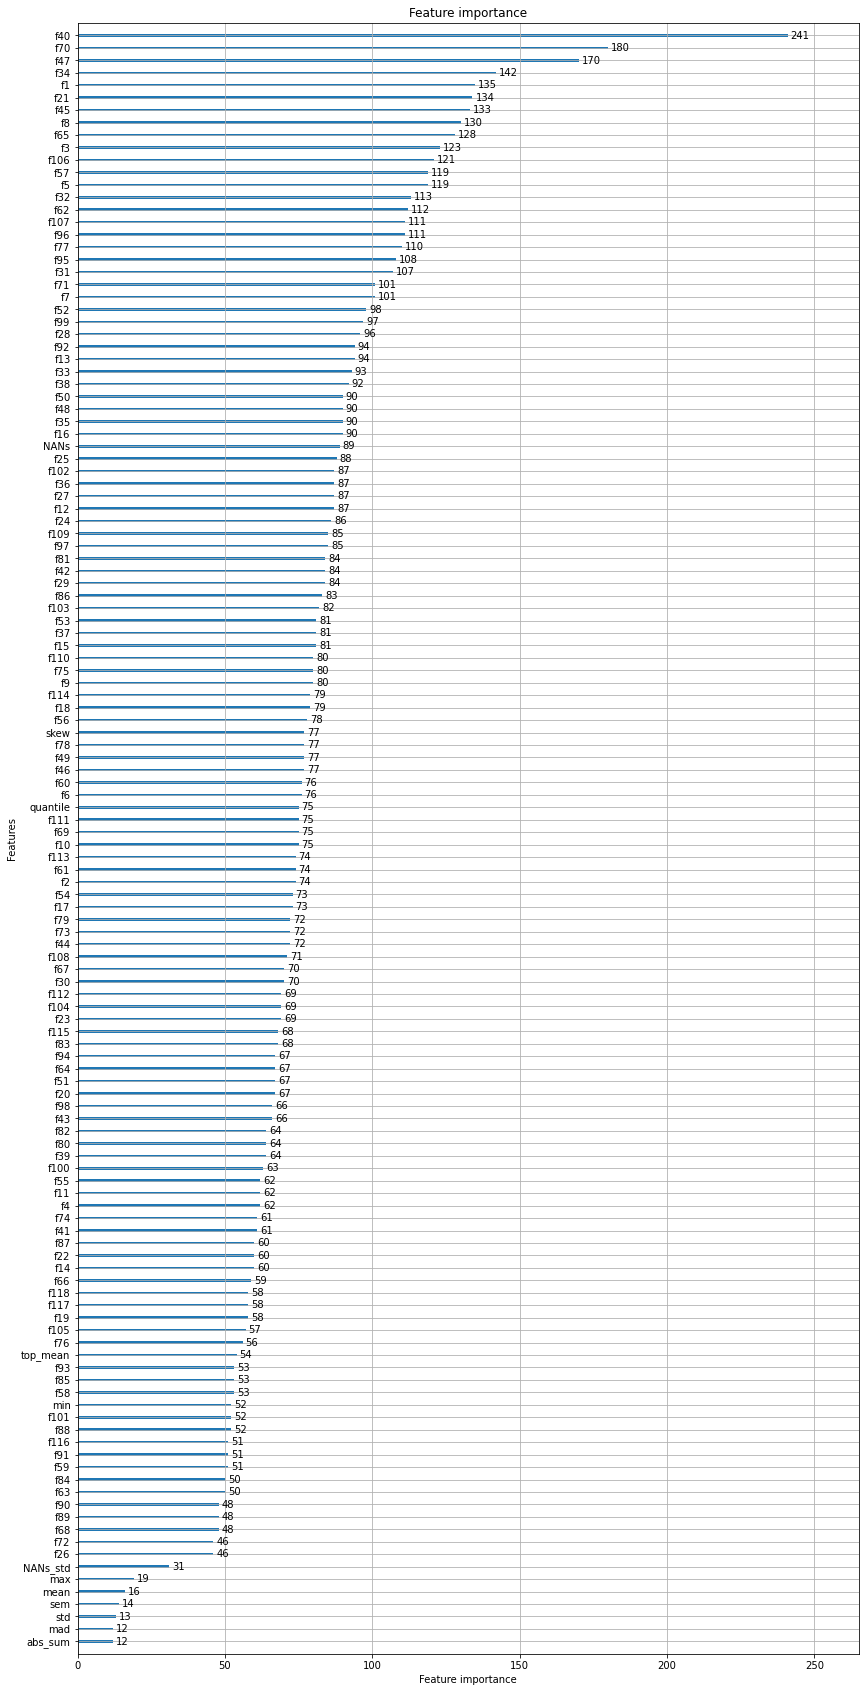

In [12]:
# lgb.plot_importance(model,figsize=(14,30))
lgb.plot_importance(fold_models[0],figsize=(14,30))

### Model Predictions

First I am ging to read in the sample submission to make sure I am correctly formatting my true submission. I am then preproccessing the test data, making predictions, and then submitting them to an output file.

In [13]:
#preprocessing test_data
# test_df = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')
# submission_df = test_df['id'].to_frame()
# test_df = test_df.drop(columns=['id'], axis=0)

#adding feats
# test_df['NANs'] = test_df.isnull().sum(axis=1)
# test_df['std'] = test_df.std(axis=1)
# test_df['skew'] = test_df.skew(axis=1)
# test_df['mean'] = test_df.mean(axis=1)
# test_df["top_mean"] = test_df[["f40","f70","f47","f34","f35","f45"]].mean(axis=1)

#fitting scaler
# test_df = pd.DataFrame(scaler.fit_transform(test_df),columns = test_df.columns)
# test_df[test_df < 0] = 0
# test_df[test_df > 1] = 1

Again note we are taking the second column of predict_proba, as this is the probability that we think the case is of label 1.

In [14]:
# #Making predictions and creating csv
# submission_df['claim'] = model.predict_proba(test_df)[:,1]
# submission_df.to_csv("submission.csv", index=False)

# submission_df

### Multi-Fold Model Predictions

Predictions for unseen data with multi-fold model.

In [15]:
all_preds = np.zeros(len(test_df))

for i in range(len(fold_models)):
    all_preds += fold_models[i].predict_proba(test_df)[:,1]
    
all_preds /= len(fold_models)
submission_df['claim'] = all_preds
submission_df.to_csv("submission.csv", index=False)

submission_df

,id,claim
0,957919,0.585608
1,957920,0.116611
2,957921,0.625540
3,957922,0.131613
4,957923,0.144500
...,...,...
493469,1451388,0.822037
493470,1451389,0.104418
493471,1451390,0.781920
493472,1451391,0.128109


### Final Thoughts

I noticed a few of the models parameters in the test data were mapped directly to the max/min of 0 or 1. I wonder what these variables are? More exploration needed.

Hopefully I find some time to improve upon this notebook. Constructive Criticism welcomed!